In [1]:
import json, os, sys, math, time, random

import numpy as np
import matplotlib.pyplot as plt

from utils import *

In [2]:
with open('msd-data/features.json', 'r') as f:
    all_features = json.load(f)

In [3]:
# Computes approximate sinusoity between the straight line from source to target and the actual path
# https://en.wikipedia.org/wiki/Sinuosity
def sinusoity(straight_line_distance: float, path: list[str], source: str, dest: str, distance_function):
    total_distance = 0
    path = [source, *path, dest]

    for i in range(len(path) - 1):
        start_feats = all_features[path[i]]
        end_feats = all_features[path[i+1]]
        
        total_distance += distance_function(start_feats, end_feats)
    
    return total_distance / straight_line_distance

In [104]:
def scatter_plot_results(RESULTS: str, distance_function, params: str):
    result_set = {}

    for result in os.listdir(RESULTS):
        with open(f'{RESULTS}/{result}') as f:
            res_data = json.load(f)
            if res_data['PATH']:
                result_set[result.strip('.json')] = res_data

    found, not_found = [], []

    for result in result_set.values():
        straight_line_distance = distance_function(result['SOURCE_FEATS'], result['TARGET_FEATS'])
        sins = sinusoity(straight_line_distance, result['PATH'], result['meta']['SOURCE_ID'], result['meta']['TARGET_ID'], distance_function)

        if result['meta']['FOUND']:
            found.append([straight_line_distance, sins])
        else:
            not_found.append([straight_line_distance, sins])

    found = np.array(found)
    not_found = np.array(not_found)

    # Filter outliers in terms of sinusoity
    std_range = 4

    found_sinusoity_std = np.std(found[:, 1])
    found_sinusoity_mean = np.mean(found[:, 1])
    found = found[abs(found[:, 1] - found_sinusoity_mean) < std_range * found_sinusoity_std]

    not_found_sinusoity_std = np.std(not_found[:, 1])
    not_found_sinusoity_mean = np.mean(not_found[:, 1])
    not_found = not_found[abs(not_found[:, 1] - not_found_sinusoity_mean) < std_range * not_found_sinusoity_std]

    fig, ax = plt.subplots()
    ax.spines['bottom'].set_color('white')
    ax.spines['left'].set_color('white')
    
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.tick_params(colors='white', which='both')

    fig.set_figheight(10)
    fig.set_figwidth(10)
    ax.set_xlabel('Straight-Line Distance')
    ax.set_ylabel('Path Sinusoity')
    ax.set_title(f'Sinusoity-Distance Scatter Plot: {params}', color='white')

    found_color = '#eeee00'
    not_found_color = '#660066'

    ax.scatter(found[:, 0], found[:, 1], c=[found_color for _ in found], label='Found Paths')
    ax.scatter(not_found[:, 0], not_found[:, 1], c=[not_found_color for _ in not_found], label='Not Found Paths')
    ax.legend()


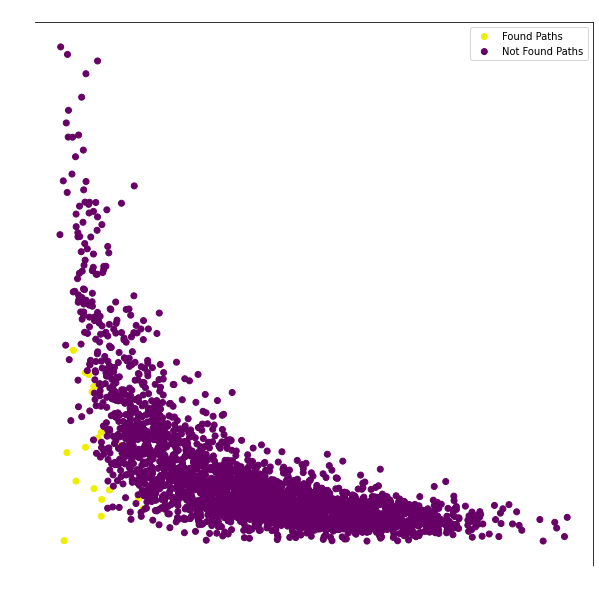

In [105]:
scatter_plot_results('msd-results/results-n=10-d=1000-l=1', feature_distance_l1, 'n=10, d=1000, l=1')
# scatter_plot_results('msd-results/results-n=10-d=1000-l=2', feature_distance_l2, subplot=(1, 2, 2))


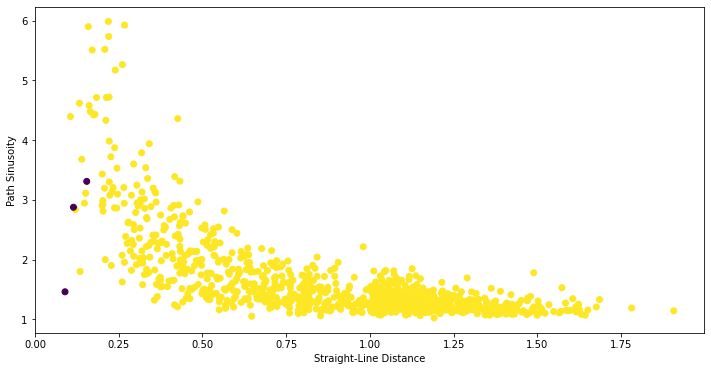

In [6]:
scatter_plot_results('msd-results/results-n=10-d=1000-l=2', feature_distance_l2)